In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from glob import glob
import pickle
from collections import OrderedDict

import matplotlib as mpl
mpl.rcParams["savefig.dpi"] = 600
#mpl.rcParams["font.size"] = 20
mpl.rcParams["lines.linewidth"] = 2
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

Results files should be made previously using:
`./alt_aggregate_results.py` and by setting the correct `date` and `regions`

In [2]:
test = False
#test = True

pdf = True
svg = True

xlab = 'Number of years of input data'

ALT_YRS = False
#ALT_YRS = True
if ALT_YRS:
    xlab = 'Median number of unique\nyears of input data'

yrs_nums_alt = [1, 2, 3, 4, 5, 7, 9, 13, 20, 26.5]
yrs_labs_alt = ['1', '', '3', '', '5', '7', '9', '13', '20', '26.5']

norm = {
    'ERCOT' : 26308, # Mean demand (MW) for file ERCOT_demand_synthetic_1950-2020_MEM.csv
    'CONUS' : 303461, # Mean demand (MW) for file CONUS_demand_synthetic_1950-2020_MEM.csv
}

title_map = {
    'SWB' : 'Solar + wind + battery',
    'SWBNG' : 'Solar + wind +\nbattery + natural gas',
    'SWBPGP' : 'Solar + wind +\n'+r'battery + H$_{2}$'
}

In [3]:
def build_associated_df_NEW(df):
    
    cols = ['syst_cost', 'lost_load']
    for c in df.columns:
        if 'capacity' in c:
            cols.append(c)
    
    DF = {'n_years' : []}
    
    vals = ['min', 'max', 'mean', 'median', '05p', '25p', '75p', '90p', '95p', 'std']
    
    for col in cols:
        for val in vals:
            DF[f"{col}_{val}"] = []
    
    for NYEARS in df['n_years'].unique():
        tmp = df.loc[ (df['n_years'] == NYEARS) ]#& (df['test_year'] > 0) ]
        
        ### Some files did not finish
        if len(tmp.index) == 0:
            continue
        
        DF['n_years'].append(NYEARS)
        
        for col in cols:
            
            DF[f"{col}_min"].append(np.min(tmp[col]))
            DF[f"{col}_max"].append(np.max(tmp[col]))
            DF[f"{col}_mean"].append(np.mean(tmp[col]))
            DF[f"{col}_median"].append(np.median(tmp[col]))
            DF[f"{col}_05p"].append(np.percentile(tmp[col], 5))
            DF[f"{col}_25p"].append(np.percentile(tmp[col], 25))
            DF[f"{col}_75p"].append(np.percentile(tmp[col], 75))
            DF[f"{col}_90p"].append(np.percentile(tmp[col], 90))
            DF[f"{col}_95p"].append(np.percentile(tmp[col], 95))
            DF[f"{col}_std"].append(np.std(tmp[col]))
    
    DF = pd.DataFrame(DF)
    
    return DF

In [4]:
file_key = {
    'CONUS' : {
        'SWB' : ['Jan29v1',],
        'SWBNG' : ['Jan29v1',],
        'SWBPGP' : ['Jan29v1',],
        #'SWB' : ['Nov29v1', 'Dec07v1'],
        #'SWBNG' : ['Nov29v1', 'Dec07v1'],
        #'SWBPGP' : ['Nov29v1', 'Dec07v1'],
    },
    #'ERCOT' : {
    #    'SWB' : ['Nov22v8maz', 'Nov23v1', 'Dec07v1'],
    #    'SWBNG' : ['Nov22v9maz', 'Nov23v1', 'Dec07v1'],
    #    'SWBPGP' : ['Nov22v8maz', 'Nov23v1', 'Dec07v1'],
    #},
}

def aggregate_results_files(region, techs, dates, post):
    
    files = [f"n_years_{date}_{region}_{techs}{post}.csv" for date in dates]
    
    for i, f in enumerate(files):
        
        print(f"loading: {f}")
        
        if i == 0:
            df = pd.read_csv(f, index_col=False)
        else:
            tmp = pd.read_csv(f, index_col=False)
            df = df.append(tmp)
    
    return df

def load_data(file_key, test):

    post = '' if not test else '_TestArchs'
    dfs = {}
    df2s = {}
    for region, tech_list in file_key.items():
        print(region)
        dfs[region] = {}
        df2s[region] = {}
        for techs, dates in tech_list.items():
            print(f" --- {techs}, {dates}")
            
            df = aggregate_results_files(region, techs, dates, post)
            df = df.sort_values(by=['n_years', 'scale_factor'])
            df.to_csv(f"n_years_ALL_{region}_{techs}{post}.csv", index=False)
            dfs[region][techs] = df
            for NYEARS in df['n_years'].unique():
                print(f" ------ {NYEARS}: {len(df.loc[ df['n_years'] == NYEARS ].index)}")
    
            print(f" ------ TOTAL: {len(dfs[region][techs].index)}")
    
            df2 = build_associated_df_NEW(df)
            #print(df2)
            df2s[region][techs] = df2

    return dfs, df2s


dfs, df2s = load_data(file_key, test)

CONUS
 --- SWB, ['Jan29v1']
loading: n_years_Jan29v1_CONUS_SWB.csv
 ------ 1: 500
 ------ 2: 500
 ------ 3: 500
 ------ 4: 500
 ------ 5: 500
 ------ 7: 500
 ------ 10: 500
 ------ 15: 150
 ------ 25: 150
 ------ 40: 20
 ------ 42: 1
 ------ TOTAL: 3821
 --- SWBNG, ['Jan29v1']
loading: n_years_Jan29v1_CONUS_SWBNG.csv
 ------ 1: 500
 ------ 2: 500
 ------ 3: 500
 ------ 4: 500
 ------ 5: 500
 ------ 7: 500
 ------ 10: 500
 ------ 15: 150
 ------ 25: 150
 ------ 40: 20
 ------ 42: 1
 ------ TOTAL: 3821
 --- SWBPGP, ['Jan29v1']
loading: n_years_Jan29v1_CONUS_SWBPGP.csv
 ------ 1: 500
 ------ 2: 500
 ------ 3: 500
 ------ 4: 500
 ------ 5: 500
 ------ 7: 500
 ------ 10: 500
 ------ 15: 150
 ------ 25: 150
 ------ 40: 20
 ------ 42: 1
 ------ TOTAL: 3821


# SI Figure

CONUS dict_keys(['SWB', 'SWBNG', 'SWBPGP'])
SWB
Len variables 4
storage, don't percentile
Saving: plots/all_Jan29v1_CONUS_SWB.png
SWBNG
Len variables 5
storage, don't percentile
Saving: plots/all_Jan29v1_CONUS_SWBNG.png
SWBPGP
Len variables 7
storage, don't percentile
storage, don't percentile
Saving: plots/all_Jan29v1_CONUS_SWBPGP.png


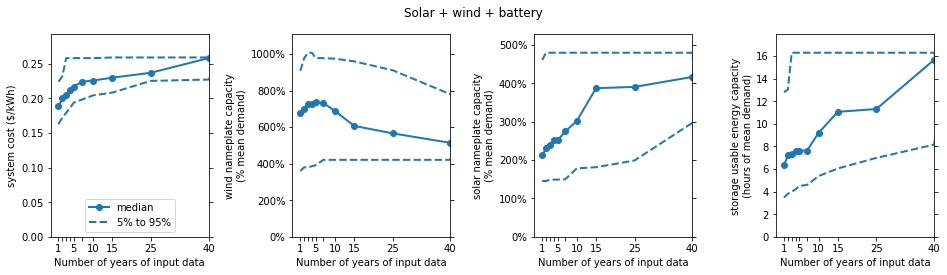

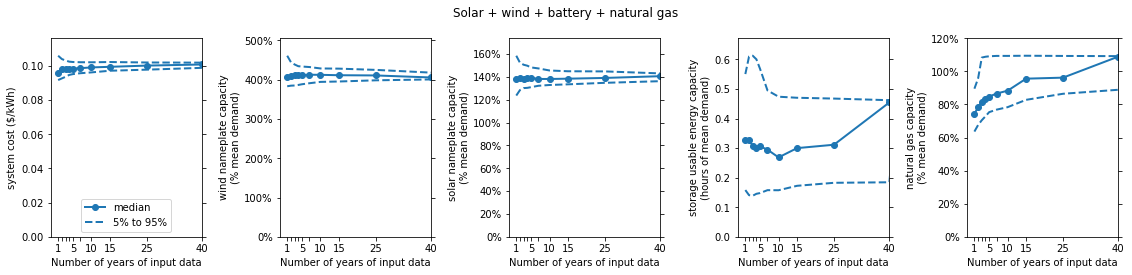

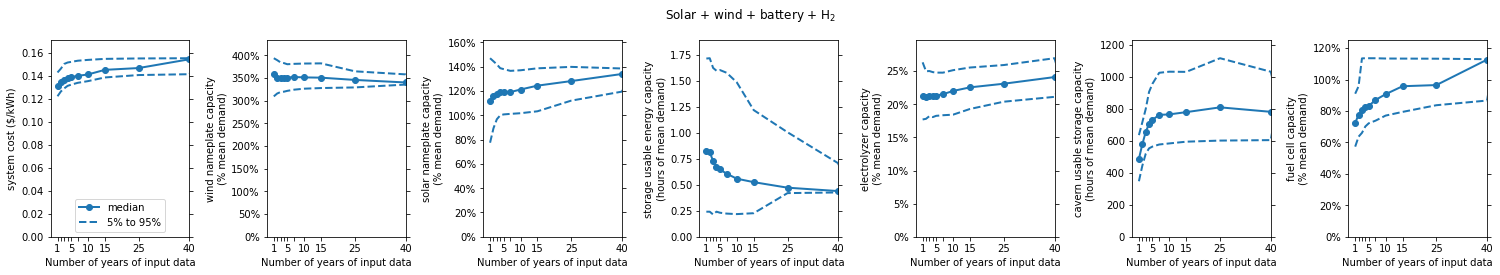

In [5]:
def plot_SFs_for_region(save_name, df, variables, **kwargs):
    
    
    cols = len(variables)
    
    big = .8
    fig, axs = plt.subplots(ncols=cols, figsize=(3+cols*3.2*big, 4.8*big))
    if cols == 1:
        axs = [axs,]
    
    print(f"Len variables {len(variables)}")
    fig.patch.set_facecolor('white')
    
    for i, var in enumerate(variables):
        #if i == 1:
        #    continue
        
           
        kwargs['add_std'] = var
        var1 = f'{var}_mean'
        l1 = 'mean'
        if 'percentile' in kwargs.keys() and kwargs['percentile']:
            var1 = f'{var}_median'
            l1 = 'median'
        #print(var1)
            
        yrs = df['n_years']
        #if cnt == 0:
        
        # Just added y-axis that we're showing power capacity
        denom = norm[region]
        if 'cavern' in var:
            denom = denom * 0.7 # Fuel cell efficiency so we convert to usable energy
        
            
        p = axs[i].plot(yrs, df[var1]/denom, marker='o', linestyle='-', label=l1)
        #axs[i].plot(yrs, df[f"{var}_mean"]/denom, c=p[-1].get_color(), ls='-.', label=r"mean")
        #else:
        #    p = axs[i].plot(yrs, df[var1], color=p[-1].get_color(), marker='.', linestyle=':', label=f"_nolabel_")
            

        # All others
        MAX_Y = 0
        if 'add_std' in kwargs.keys():
            bottom = df[var1] - df[f'{kwargs["add_std"]}_std']
            top = df[var1] + df[f'{kwargs["add_std"]}_std']
            if 'percentile' in kwargs.keys() and kwargs['percentile']:
                #print(kwargs['percentile'])
                bottom = df[f'{kwargs["add_std"]}_25p']
                top = df[f'{kwargs["add_std"]}_75p']
            if False:
                axs[i].fill_between(yrs, (bottom)/denom,
                            (top)/denom, 
                            alpha=0.3, facecolor=p[-1].get_color(), 
                            label=r"25% to 75%")
            #axs[i].plot(yrs, df[f"{var}_max"]/denom, c=p[-1].get_color(), ls='--', label=r"min & max")
            #axs[i].plot(yrs, df[f"{var}_min"]/denom, c=p[-1].get_color(), ls='--', label=r"_nolabel_")
            axs[i].plot(yrs, df[f"{var}_05p"]/denom, c=p[-1].get_color(), ls='--', label=r"5% to 95%")
            axs[i].plot(yrs, df[f"{var}_95p"]/denom, c=p[-1].get_color(), ls='--', label=r"_nolabel_")
            MAX_Y = np.max(df[f"{var}_95p"]/denom)
                
        # Add the optimal solution if included in df
        #MAX_YEARS = 71
        MAX_YEARS = -1 # 42
        if MAX_YEARS in yrs.values:
            val = df.loc[ df['n_years'] == MAX_YEARS ][var1].sum()/denom
            #print(var1, val)
            axs[i].plot(yrs, np.ones(len(yrs.index))*val, 
                        linewidth=2, ls=':', color='r', label=f'{MAX_YEARS} year optimal')
        
        
        axs[i].set_xlabel(xlab)
        yrs_labs = []
        for y in yrs:
            skip_lab = [] if np.max(yrs) == 5 else [2, 3, 4, 7]
            yrs_labs.append(str(y)) if y not in skip_lab else yrs_labs.append('')
        axs[i].set_xticks(yrs)
        axs[i].set_xticklabels(yrs_labs)
        
        
        if 'y_labs' in kwargs.keys():
            axs[i].set_ylabel(kwargs['y_labs'][i])
            if 'hours of mean demand' in kwargs['y_labs'][i]:
                print("storage, don't percentile")
            elif 'capacity' in kwargs['y_labs'][i] or 'lost' in kwargs['y_labs'][i]:
                deci = 0 if 'capacity' in kwargs['y_labs'][i] else 1
                axs[i].yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1, decimals=deci))
        if 'y_min' in kwargs.keys():
            axs[i].set_ylim(kwargs['y_min'], MAX_Y*1.1)
        axs[i].set_xlim(axs[i].get_xlim()[0], kwargs['max_yr'])
        if 40 in yrs.values:
            axs[i].set_xlim(axs[i].get_xlim()[0], 40)
        axs[i].tick_params(right=True)
            

    if 'sup_title' in kwargs.keys():
        plt.suptitle(f"{kwargs['sup_title']}")
    
    #if 'left_legend' in kwargs.keys():
    #    plt.subplots_adjust(right=.7)
    #    
    #    #if 'lostload' in variables:
    axs[0].legend(loc='lower center')#, bbox_to_anchor=(0.99, 0.8))
        
        #else:
        #    # From https://matplotlib.org/stable/gallery/text_labels_and_annotations/custom_legends.html
        #    legend_elements = [
        #        Line2D([0], [0], marker='o', color='k', alpha=.5, label=l1),
        #        Line2D([0], [0], linestyle='-.', color='k', alpha=.5, label='mean'),
        #        Line2D([0], [0],             color='k', alpha=.5, label='min & max'),
        #        Patch(facecolor='k', edgecolor=None, alpha=.5,
        #                   label='25% to 75%')]
        #    axs[-1].legend(loc='upper left', bbox_to_anchor=(0.99, 0.8),
        #                   handles=legend_elements)
        

    
    plt.tight_layout(pad=1)
    post = '' if not test else '_TestArchs'
    if pdf:
        plt.savefig(f"plots/{save_name}{post}.pdf")
    if svg:
        plt.savefig(f"plots/{save_name}{post}.svg")
    plt.savefig(f"plots/{save_name}{post}.png")
    
    print(f"Saving: plots/{save_name}{post}.png")
    return

   
def plot_vars(techs):

    kwargs = {}
    kwargs['skip_cost'] = True
    kwargs['techs'] = techs
    kwargs['y_lab'] = 'lost load\n(fraction mean demand)'
    kwargs['y_min'] = 0
    kwargs['left_legend'] = True
    kwargs['y_lab'] = 'system cost ($/kWh)'
    #del kwargs['y_min']
    kwargs['test'] = test
    
    kwargs['y_min'] = 0
    kwargs['percentile'] = False
    kwargs['percentile'] = True
    kwargs['y_labs'] = ['system cost ($/kWh)',]

    kwargs['max_yr'] = 25
    #if kwargs['techs'] == 'SWBPGP':
    #    kwargs['max_yr'] = 10
    
    variables = ['syst_cost',]
    if 'SWB' in kwargs['techs']:
        variables.append('wind capacity')
        variables.append('solar capacity')
        variables.append('storage capacity')
        kwargs['y_labs'].append('wind nameplate capacity\n(% mean demand)')
        kwargs['y_labs'].append('solar nameplate capacity\n(% mean demand)')
        kwargs['y_labs'].append('storage usable energy capacity\n(hours of mean demand)')

    if 'PGP' in kwargs['techs']:
        variables.append('to_PGP capacity')
        variables.append('PGP_storage capacity')
        variables.append('from_PGP capacity')
        kwargs['y_labs'].append('electrolyzer capacity\n(% mean demand)')
        kwargs['y_labs'].append('cavern usable storage capacity\n(hours of mean demand)')
        kwargs['y_labs'].append('fuel cell capacity\n(% mean demand)')
   
    if 'NG' in kwargs['techs']:
        variables.append('natgas capacity')
        kwargs['y_labs'].append('natural gas capacity\n(% mean demand)')

    return variables, kwargs
    

for region, tech_list in dfs.items():
    print(region, tech_list.keys())

    for techs, df in tech_list.items():
        print(techs)
    
        variables, kwargs = plot_vars(techs)
    
        dates = file_key[region][techs]
        
        T = title_map[techs].replace('\n', ' ')
        kwargs['sup_title'] = f"{T}"
        plot_SFs_for_region(f"all_{'_'.join(dates)}_{region}_{techs}",
                df2s[region][techs], variables, **kwargs)


#variables = ['lost_load',]
#kwargs['y_labs'] = ['lost load\n(% mean demand)',]
#for region, dates in regions.items():
#    plot_SFs_for_region(f"all_{'_'.join(dates)}_{region}_{kwargs['techs']}_LL",
#                df2s[region], variables, max_yr, **kwargs)


# Figure 1b

CONUS dict_keys(['SWB', 'SWBNG', 'SWBPGP'])
SWB Len variables 4
skipping syst_cost
SWB, 1, wind capacity, 6.492334, -0.184
SWB, 2, solar capacity, 2.424435, 0.707
SWB, 3, storage capacity, 6.870645, 1.093
SWBNG Len variables 5
skipping syst_cost
SWBNG, 1, wind capacity, 4.118688, -0.011
SWBNG, 2, solar capacity, 1.387792, 0.010
SWBNG, 3, storage capacity, 0.334227, 0.187
SWBNG, 4, natgas capacity, 0.752786, 0.390
SWBPGP Len variables 7
skipping syst_cost
SWBPGP, 1, wind capacity, 3.545038, -0.030
SWBPGP, 2, solar capacity, 1.143619, 0.149
SWBPGP, 3, storage capacity, 0.872321, -0.414
SWBPGP, 4, to_PGP capacity, 0.213621, 0.131
SWBPGP, 5, PGP_storage capacity, 488.716166, 0.618
SWBPGP, 6, from_PGP capacity, 0.736411, 0.453
[1, 2, 3, 4, 5, 7, 10, 15, 25, 40]
Saving: plots/fig1_capacities.png


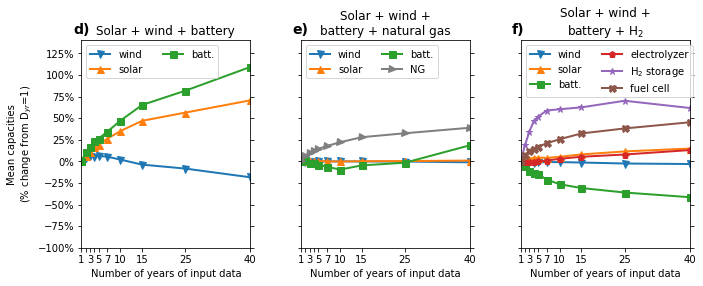

In [6]:
label_map = {
    'syst_cost' : 'cost',
    'wind capacity' : 'wind',
    'solar capacity' : 'solar',
    'storage capacity' : 'batt.',
    'natgas capacity' : 'NG',
    'to_PGP capacity' : 'electrolyzer',
    'PGP_storage capacity' : r'H$_{2}$ storage',
    'from_PGP capacity' : 'fuel cell'
}

def plot_summary_values(save_name, dfs):
    
    cols = len(dfs.keys())
    fig, axs = plt.subplots(ncols=cols, sharey=True, figsize=((3+cols*3)*.8, 4.8*.8))
    if cols == 1:
        axs = [axs,]
    fig.patch.set_facecolor('white')    
    
    M = ['o', 'v', '^', 's', 'p', '*', 'X', '<', '>']
    
    Med = 'Mean'
    i = 0
    MAX = 2 # TMP
    results = OrderedDict()
    
    
    label_dict = {
        0 : "d)",
        1 : "e)",
        2 : "f)"
    }
    for techs, df in dfs.items():
        df2 = df[ df['n_years'] <= 40 ]
        variables, kwargs = plot_vars(techs)
        print(techs, f"Len variables {len(variables)}")
    
        yrs = df2['n_years']
        if not ALT_YRS:
            axs[i].set_title(title_map[techs])
        else:
            yrs = yrs_nums_alt
        axs[i].text(-0.05, 1.03, label_dict[i], fontsize=14, weight='bold', transform=axs[i].transAxes)
    
        for j, var in enumerate(variables):
            
            if var == 'syst_cost':
                print("skipping syst_cost")
                continue
            
            denom = norm[region]
            if 'cavern' in var:
                denom = denom * 0.7 # Fuel cell efficiency so we convert to usable energy
            
            one_year_val = df2.iloc[0][f"{var}_{Med.lower()}"]/denom
            ys = (df2[f"{var}_{Med.lower()}"]/denom)/one_year_val
            ys -= 1
            out = list(ys)
            results[f"{techs}, {var}"] = out
            nyrs = list(yrs)
            print(f"{techs}, {j}, {var}, {one_year_val:01f}, {out[-1]:.3f}")
            if 'natgas' in var: # this is to set markers and color diff than electrolyzer
                axs[i].plot(yrs, ys, marker=M[-1], 
                        markersize=7, linestyle='-', color='C7', label=label_map[var])
            else:
                axs[i].plot(yrs, ys, marker=M[j], 
                        markersize=7, linestyle='-', label=label_map[var])
        
        if not ALT_YRS:
            axs[i].set_xlabel(xlab)
        yrs_labs = []
        for y in df2['n_years']:
            skip_lab = [] if np.max(df2['n_years']) == 5 else [2, 4]
            yrs_labs.append(str(y)) if y not in skip_lab else yrs_labs.append('')
        if ALT_YRS:
            axs[i].set_xticks(yrs_nums_alt)
            #axs[i].set_xticklabels(yrs_labs_alt)
            axs[i].set_xticklabels(['' for _ in yrs_labs_alt])
            axs[i].set_xlim(yrs_nums_alt[0], yrs_nums_alt[-1])
        else:
            axs[i].set_xticks(df2['n_years'])
            axs[i].set_xticklabels(yrs_labs)
            axs[i].set_xlim(1, 40)
        
        
        axs[i].set_ylim(0, axs[i].get_ylim()[1])
        if i == 0:
            axs[i].set_ylabel(f'{Med} capacities\n(% change from '+r'D$_{yr}$=1)')
        axs[i].tick_params(right=True)
        axs[i].yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1, decimals=0))
        axs[i].yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.25))
        axs[i].legend(loc='upper left', ncol=2)
        i += 1
    print(nyrs)
    #for k, v in results.items():
    #    print(k, v)
    for ax in axs:
        ax.set_ylim(-1, 1.4)
    
    #plt.tight_layout(pad=1)
    plt.subplots_adjust(left=.11, right=.99, wspace=.3, bottom=.13, top=.88)

    if pdf:
        plt.savefig(f"plots/{save_name}.pdf")
    if svg:
        plt.savefig(f"plots/{save_name}.svg")
    plt.savefig(f"plots/{save_name}.png")
    print(f"Saving: plots/{save_name}.png")
    return
    
for region, tech_list in dfs.items():
    print(region, tech_list.keys())

    #kwargs['sup_title'] = f"{region}"#": wind+solar+storage system"
    plot_summary_values("fig1_capacities",
            df2s[region])

# Figure 1a

In [7]:
costs = pd.read_csv('N_YEARS_COST_DATA.csv')
costs

,tech_name,tech_type,node_from,node_to,series_file,normalization,capacity,fixed_cost,var_cost,charging_time,efficiency,decay_rate,mean_dispatch,var_co2
0,demand,demand,main_node,NaN,CONUS_demand_synthetic_1950-2020_MEM.csv,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,lost_load,lost_load,NaN,main_node,NaN,NaN,NaN,NaN,10.000000,NaN,NaN,NaN,0.0,NaN
2,main_node_curtailment,curtailment,main_node,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,natgas,generator,NaN,main_node,NaN,NaN,NaN,0.010163,0.020970,NaN,NaN,NaN,NaN,0.461
4,solar,fixed_generator,NaN,main_node,20210921_US_mthd3_1950-2020_solar.csv,NaN,NaN,0.014800,NaN,NaN,NaN,NaN,NaN,NaN
5,wind,fixed_generator,NaN,main_node,20210921_US_mthd3_1950-2020_wind.csv,NaN,NaN,0.016000,NaN,NaN,NaN,NaN,NaN,NaN
6,storage,storage,main_node,main_node,NaN,NaN,NaN,0.007350,NaN,4.0,0.9,1.000000e-05,NaN,NaN
7,to_PGP,transfer,main_node,h2_node,NaN,NaN,NaN,0.034609,NaN,NaN,0.7,NaN,NaN,NaN
8,PGP_storage,storage,h2_node,h2_node,NaN,NaN,NaN,0.000004,0.000001,NaN,1.0,1.140000e-08,NaN,NaN
9,from_PGP,transfer,h2_node,main_node,NaN,NaN,NaN,0.058464,0.000001,NaN,0.7,NaN,NaN,NaN


CONUS dict_keys(['SWB', 'SWBNG', 'SWBPGP'])
SWB Len variables 4
0 syst_cost
1 wind capacity
2 solar capacity
3 storage capacity
SWBNG Len variables 5
0 syst_cost
1 wind capacity
2 solar capacity
3 storage capacity
4 natgas capacity
SWBPGP Len variables 7
0 syst_cost
1 wind capacity
2 solar capacity
3 storage capacity
4 to_PGP capacity
5 PGP_storage capacity
6 from_PGP capacity
Saving: plots/fig1_costs.png


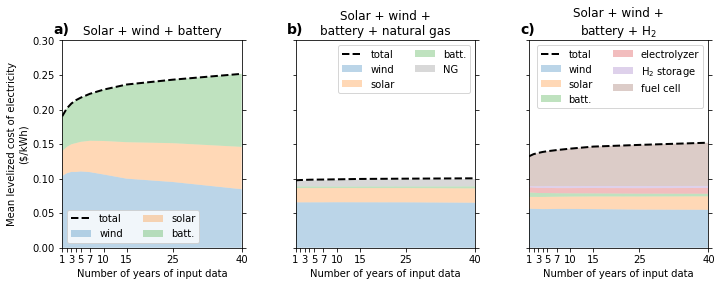

In [8]:
label_map = {
    'syst_cost' : 'total',
    'wind capacity' : 'wind',
    'solar capacity' : 'solar',
    'storage capacity' : 'batt.',
    'natgas capacity' : 'NG',
    'to_PGP capacity' : 'electrolyzer',
    'PGP_storage capacity' : r'H$_{2}$ storage',
    'from_PGP capacity' : 'fuel cell'
}

def plot_stacked_costs(save_name, dfs):
    
    cols = len(dfs.keys())
    fig, axs = plt.subplots(ncols=cols, sharey=True, figsize=((3+cols*3*.8), 4.8*.8))
    if cols == 1:
        axs = [axs,]
    fig.patch.set_facecolor('white')    
    
    denom = norm[region]
    
    label_dict = {
        0 : "a)",
        1 : "b)",
        2 : "c)"
    }
    
    VAL = 'mean'
    i = 0
    MAX = .3 # TMP
    outs = OrderedDict()
    for techs, df in dfs.items():
        df2 = df[ df['n_years'] <= 40 ]
        if 'n_years' not in outs.keys():
            outs['n_years'] = df2['n_years']
        variables, kwargs = plot_vars(techs)
        print(techs, f"Len variables {len(variables)}")
        
        yrs = df2['n_years']
        if ALT_YRS:
            yrs = yrs_nums_alt
        
        axs[i].set_title(title_map[techs])
        axs[i].text(-0.05, 1.03, label_dict[i], fontsize=14, weight='bold', transform=axs[i].transAxes)
    
        bottom = np.zeros(len(df2.index))
        for j, var in enumerate(variables):
            print(j, var)
            
            if var == 'syst_cost':
                axs[i].plot(yrs, df2[f"{var}_{VAL}"]/denom, 'k--', label=label_map[var])
                outs[f'{techs} {var}'] = list(df2[f"{var}_{VAL}"]/denom)
            else:
                cost = costs.loc[ costs['tech_name'] == var.replace(' capacity',''), 'fixed_cost'].sum()
                
                if 'natgas' in var:
                    axs[i].fill_between(yrs, bottom, bottom+df2[f"{var}_{VAL}"]*cost/denom, alpha=0.3, facecolor='C7', label=label_map[var])
                else:
                    axs[i].fill_between(yrs, bottom, bottom+df2[f"{var}_{VAL}"]*cost/denom, alpha=0.3, label=label_map[var])
                bottom += df2[f"{var}_{VAL}"]*cost/denom
                outs[f'{techs} {var}'] = list(df2[f"{var}_{VAL}"]*cost/denom)
        
        if not ALT_YRS:
            axs[i].set_xlabel(xlab)
        yrs_labs = []
        for y in df2['n_years']:
            skip_lab = [] if np.max(df2['n_years']) == 5 else [2, 4]
            yrs_labs.append(str(y)) if y not in skip_lab else yrs_labs.append('')
        axs[i].set_xticks(yrs)
        if ALT_YRS:
            axs[i].set_xticklabels(yrs_labs_alt)
            axs[i].set_xticklabels(['' for _ in yrs_labs_alt])
            axs[i].set_xlim(yrs[0], yrs[-1])
        else:
            axs[i].set_xticklabels(yrs_labs)
            axs[i].set_xlim(1, 40)
        
        
        axs[i].set_ylim(0, axs[i].get_ylim()[1])
        if i == 0:
            axs[i].set_ylabel('Mean levelized cost of electricity\n($/kWh)')
        axs[i].tick_params(right=True)
        if axs[i].get_ylim()[1] > MAX:
            MAX = axs[i].get_ylim()[1]
        axs[i].legend(ncol=2)
        i += 1
    
    for ax in axs:
        ax.set_ylim(0, MAX)
    #for k, v in outs.items():
    #    print(k, v)
    outs_df = pd.DataFrame(outs)
    outs_df.to_csv('cost_values_fig1a.csv')
    
    #plt.tight_layout(pad=1)
    plt.subplots_adjust(left=.11, right=.99, wspace=.3, bottom=.13, top=.88)
    
    plt.savefig(f"plots/{save_name}.png")
    if pdf:
        plt.savefig(f"plots/{save_name}.pdf")
    if svg:
        plt.savefig(f"plots/{save_name}.svg")
    print(f"Saving: plots/{save_name}.png")
    return
    
for region, tech_list in dfs.items():
    print(region, tech_list.keys())

    #kwargs['sup_title'] = f"{region}"#": wind+solar+storage system"
    plot_stacked_costs(f"fig1_costs",
            df2s[region])